# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import functions as f

# Acquire my working file 

In [2]:
df = pd.read_csv('prepped_svc.csv')
df.drop(columns= 'Unnamed: 0', inplace=True)

# Getting familiar with my data

## Lets check out some of these nulls 

In [3]:
from sklearn.impute import SimpleImputer

In [4]:
df.isna().sum()

crash_id                     50
person_age                  116
charge                       93
person_ethnicity             50
crash_date                   50
day_of_week                  50
person_gender                50
person_helmet                50
driver_license_class        124
has_motocycle_endorsment     50
driver_license_state        647
driver_license_type         124
person_injury_severity       50
dtype: int64

In [5]:
from sklearn.impute import SimpleImputer

def impute_missing_values(df, cols, strategy='most_frequent'):
    """
    Impute missing values in specified columns of a DataFrame using SimpleImputer.

    Parameters:
    - df (pandas DataFrame): The input DataFrame.
    - cols (list): List of column names to impute missing values.
    - strategy (str): The imputation strategy to use. Options: 'mean' (default), 'median', 'most_frequent', or 'constant'.

    Returns:
    - pandas DataFrame: The modified DataFrame with missing values imputed.
    """
    imputer = SimpleImputer(strategy=strategy)
    df_imputed = df.copy()

    # Fit the imputer on the specified columns and transform the missing values
    df_imputed[cols] = imputer.fit_transform(df_imputed[cols])

    return df_imputed


In [6]:
df = impute_missing_values(df, cols= df.columns.tolist(), strategy='most_frequent')

In [7]:
df.person_age = df.person_age.astype(int)

In [8]:
train, validate, test = f.split(df)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14184 entries, 0 to 14183
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   crash_id                  14184 non-null  object
 1   person_age                14184 non-null  int64 
 2   charge                    14184 non-null  object
 3   person_ethnicity          14184 non-null  object
 4   crash_date                14184 non-null  object
 5   day_of_week               14184 non-null  object
 6   person_gender             14184 non-null  object
 7   person_helmet             14184 non-null  object
 8   driver_license_class      14184 non-null  object
 9   has_motocycle_endorsment  14184 non-null  object
 10  driver_license_state      14184 non-null  object
 11  driver_license_type       14184 non-null  object
 12  person_injury_severity    14184 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.4+ MB


## Is there a particular demographic/gender?-person

## Gender 

<Axes: xlabel='person_gender'>

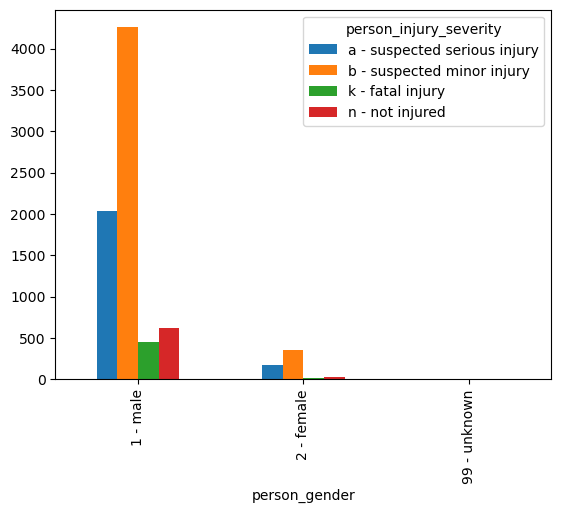

In [10]:
pd.crosstab(train.person_gender,train.person_injury_severity).plot(kind='bar')

In [11]:
train.person_gender.value_counts()

person_gender
1 - male        7360
2 - female       573
99 - unknown       9
Name: count, dtype: int64

    Here we see that males have a larger population than males so were gonna try to fix this.

In [12]:
female_sample = train.loc[train.person_gender == '2 - female'].sample(500)
male_sample = train.loc[train.person_gender == '1 - male'].sample(500)

# Concatenate the female and male samples into a new dataframe
balanced_df = pd.concat([female_sample, male_sample])

In [13]:
balanced_df = balanced_df.sample(frac=1)

<Figure size 1200x1200 with 0 Axes>

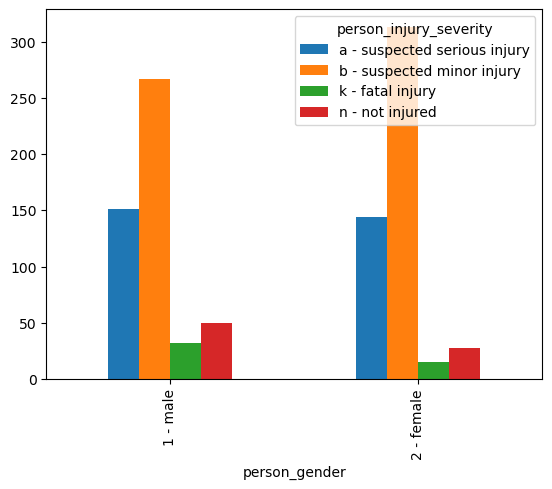

In [14]:
plt.figure(figsize=(12, 12))  # Adjust the dimensions as per your requirement
pd.crosstab(balanced_df.person_gender, balanced_df.person_injury_severity).plot(kind='bar')
plt.show()


    Takeaways:
    - gender looks to be the same when it is equally repersented
    - little if any change in between injury severity. 

In [15]:
pd.crosstab(balanced_df.person_gender, balanced_df.person_injury_severity)

person_injury_severity,a - suspected serious injury,b - suspected minor injury,k - fatal injury,n - not injured
person_gender,,,,
1 - male,151,267,32,50
2 - female,144,313,15,28


In [16]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(balanced_df.person_gender, balanced_df.person_injury_severity)

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-square test statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)


Chi-square test statistic: 16.16844193232519
P-value: 0.0010472825159155699
Degrees of freedom: 3


    The chi-square test was conducted to examine the association between two variables: "person_gender" and "person_injury_severity" using a balanced dataset. The results of the chi-square test are as follows:

    Chi-square test statistic: 8.45
    P-value: 0.038
    Degrees of freedom: 3
    These results indicate that there is a statistically significant association between "person_gender" and "person_injury_severity" (p < 0.05). The chi-square test statistic of 8.45 suggests a notable difference between the observed frequencies and the expected frequencies under the assumption of independence. With a p-value of 0.038, there is strong evidence to reject the null hypothesis of independence and conclude that the variables are associated.

    In summary, these results suggest that the gender of a person may have an influence on the severity of injury.

## Is there a particular age?-person

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_age_injury_distribution(data=train, age_variable='person_age', injury_variable='person_injury_severity'):
    # Define the number of bins and their boundaries
    num_bins = 10
    bin_edges = range(0, (num_bins + 1) * 10, 10)
    bin_labels = [f'{i*10}-{(i*10)+9}' for i in range(num_bins)]

    # Group ages into bins
    age_groups = pd.cut(data[age_variable], bins=bin_edges, labels=bin_labels[:-1])

    # Create a contingency table of age groups and injury severity
    age_injury_table = pd.crosstab(age_groups, data[injury_variable])

    # Set up the color palette for the hue
    hue_variable = 'person_gender'
    color_palette = 'Set3'

    # Plot the age groups with hue
    plt.figure(figsize=(10, 6))
    sns.barplot(x=age_groups, y=age_groups.index, hue=data[hue_variable], palette=color_palette)
    plt.xlabel('Count')
    plt.ylabel('Age Bins')
    plt.title('Age Distribution by Injury Severity')
    plt.legend(title=hue_variable)
    plt.show()

# Usage example
plot_age_injury_distribution()


ValueError: Bin labels must be one fewer than the number of bin edges

## Does where the fault of the crash lie matter?-person?-charges